# Introduction
This notebook will outline the solution to a Kaggle [competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The objective is to predict the final selling price of houses in Ames, Iowa. 

This is a supervised regression problem as we are asked to predict a continous numeric variable given labelled training data.

## Project Workflow
As a general guideline the project will follow the following steps:
1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Establish a baseline and compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible
8. Draw conclusions and write a well-documented report

It's important to note that while this appears as a linear process, it may not be that in practice. Each round of analysis, feature engineering or modelling, may lead back to a previously completed stage. For example, as we analyse the mistakes made by models, this may lead to ideas for better features or transformations. Likewise, once we have a good idea about which variables are most important as predictors, it will be useful to go back to the EDA and re-investigate what this means for our data.

## Imports
We will use the standard data science and machine learning libraries: `numpy`, `pandas`, and `scikit-learn`. We also use `matplotlib` and `seaborn` for visualization.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Data Cleaning and Formatting

## Load in the Data and Examine
The data is hosted on github in order to make this notebook accessible to anyone who executes it. 

First we'll download the data and then use `pandas` to load and explore it. Eventually we'll need to work with all the data in numpy as scikit-learn doesn't support pandas dataframes at this time, although the [sklearn-pandas](https://github.com/scikit-learn-contrib/sklearn-pandas) project aims to resolve this. 

Initially we'll combine the training and testing data so we can explore it as a whole. When it's time to handle missing values and perform predictions we'll seperate it again.

In [5]:
import os
import tarfile
from six.moves import urllib

def fetch_data(base_url, file_name, remote_sub_dir=None, file_ext="csv", base_local_path = "raw", local_store_sub_dir=None):
    '''
    Downloads file_name.file_ext from base_url & optional remote_sub_dir and stores it in relative base_local_path & 
    optional local_store_sub_dir. If file is a tarball, it will be extracted as well. 
    
    Issues: doesn't work with .csv.gz files
    '''
    if remote_sub_dir is not None:
        download_url = base_url + remote_sub_dir + file_name + "." + file_ext
    else:
        download_url = base_url + file_name + "." + file_ext
    
    if not os.path.isdir(base_local_path):
         os.makedirs(base_local_path)
            
    if local_store_sub_dir is not None:
        local_path = os.path.join(base_local_path, local_store_sub_dir)
        if not os.path.isdir(local_path):
            os.makedirs(local_path)
    else:
        local_path = os.path.join(base_local_path)
    
    
    full_file_name = file_name + "." + file_ext
    file_path = os.path.join(local_path, full_file_name)
    
    print("Downloading file:", full_file_name)
    urllib.request.urlretrieve(download_url, file_path)
    
    if file_ext in ["tgz", "tar", "gz", "tar.gz"]:
        data_tgz = tarfile.open(file_path)
        data_tgz.extractall(path=local_path)
        data_tgz.close()

In [6]:
filenames = ["train", "test", "sample_submission", "data_description"]
extensions = ["csv", "csv", "csv", "txt"]

for file, ext in zip(filenames, extensions):
    fetch_data(base_url = "https://raw.githubusercontent.com/dorond/kaggle-house-prices-prediction/master/", 
           file_name = file, 
           remote_sub_dir="raw/", 
           file_ext=ext)

In [7]:
def load_data(base_path, file, sub_dir=None, ext="csv", encoding=None):
    filename = file + "." + ext
    if sub_dir is not None:
        csv_path = os.path.join(base_path, sub_dir, filename)
    else:
        csv_path = os.path.join(base_path, filename)
    return pd.read_csv(csv_path)

In [8]:
base_path = "raw/"
train = load_data(base_path, "train")
test = load_data(base_path, "test")

In [9]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train, test], ignore_index=True, sort=False)
print (train.shape, test.shape, data.shape)

(1460, 82) (1459, 81) (2919, 82)


In [11]:
data.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,source
2030,2031,120,FV,NaN,4538,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,9,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,179.0,Gd,TA,PConc,...,1,Gd,5,Typ,1,TA,Attchd,2001.0,RFn,2.0,545.0,TA,TA,Y,277,45,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,NaN,test
37,38,20,RL,74.0,8532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1954,1990,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,650.0,TA,TA,CBlock,...,1,TA,5,Typ,1,TA,Attchd,1954.0,Fin,2.0,498.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,153000.0,train
1757,1758,20,RL,NaN,9450,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1957,1957,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,160.0,TA,TA,CBlock,...,1,TA,6,Typ,1,Gd,Attchd,1982.0,RFn,3.0,768.0,TA,TA,Y,0,0,84,0,0,0,NaN,MnPrv,NaN,0,5,2009,WD,Normal,NaN,test
1395,1396,60,RL,88.0,12665,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,8,5,2005,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,245.0,Gd,TA,PConc,...,1,Gd,9,Typ,1,Gd,BuiltIn,2005.0,Fin,3.0,642.0,TA,TA,Y,144,39,0,0,0,0,NaN,NaN,NaN,0,2,2007,WD,Normal,281213.0,train
258,259,60,RL,80.0,12435,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,172.0,Gd,TA,PConc,...,1,Gd,7,Typ,1,TA,Attchd,2001.0,RFn,2.0,564.0,TA,TA,Y,0,96,0,245,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,231500.0,train
784,785,75,RM,35.0,6300,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Unf,6,6,1914,2001,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,CBlock,...,1,TA,9,Typ,1,Gd,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,291,134,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,128000.0,train
270,271,60,FV,84.0,10728,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,8,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,...,1,Gd,8,Typ,1,Gd,Attchd,2006.0,RFn,3.0,1053.0,TA,TA,Y,192,51,0,0,0,0,NaN,NaN,NaN,0,8,2006,New,Partial,266000.0,train
2482,2483,20,RL,86.0,8665,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1968,1968,Gable,CompShg,HdBoard,HdBoard,BrkFace,89.0,TA,TA,CBlock,...,1,TA,5,Typ,0,NaN,Attchd,1968.0,RFn,1.0,264.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,NaN,test
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,...,1,TA,3,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500.0,train
1027,1028,20,RL,71.0,9520,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,Stone,338.0,Gd,TA,PConc,...,1,Gd,7,Typ,1,Gd,Attchd,2008.0,RFn,3.0,800.0,TA,TA,Y,192,44,0,0,0,0,NaN,NaN,NaN,0,4,2008,New,Partial,293077.0,train


At first glance we can see there are 82 columns, many of which have missing values. 

## Data Types and Missing Values

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

Here we can confirm there are a lot of missing values, however it's also useful to note which columns have been incorrectly assigned a numerical data type when they are in fact categorical. Looking at the data dictionary, it appears that `MSSubClass` contains ordinal categorical values, which is why pandas has made it an `int64`. This will be converted to an `object` type. 

### Convert Data to Correct Types

In [17]:
data["MSSubClass"] = data["MSSubClass"].astype(str)

In [18]:
data.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


## Missing Values
Now that we have the correct column datatypes, we can start analysis by looking at the percentage of missing values in each column. Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.

In [33]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [34]:
missing_values_table(data)

Your selected dataframe has 82 columns.
There are 35 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,2909,99.7
MiscFeature,2814,96.4
Alley,2721,93.2
Fence,2348,80.4
SalePrice,1459,50.0
FireplaceQu,1420,48.6
LotFrontage,486,16.6
GarageCond,159,5.4
GarageYrBlt,159,5.4
GarageFinish,159,5.4


At first glance it might seem that we need to remove `PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu`, however after investigating the data dictionary, these values have been encoded as `No Garage` or `No Fireplace`. This is different from them being missing. Knowing that a house doesn't contain a fireplace etc. is useful information when exploring or predicting values, so these columns won't be removed. Rather, they will be imputed with a `No Fireplace` etc. value. 

In the case of the missing numerical values, these will be imputing using the mean, median and most frequent as part of a pipeline operation where we can see which option performs best. Categorical values will be imputed with the most common value. In most cases there are 5% or fewer missing values so not columns will be dropped at this stage as they may contain useful information.

# Exploratory Data Analysis
Next we'll explore and visualise the data, first one variable at a time and then across multiple variable as we look for important relationships.

We'll define a general purpose function to help us explore our variables. If the variable is numerical,  it will plpot the histogram and correlation with a target variable we specify. If it's categorical, it will plot a bar shart showing the distribution of values as well as a plot exploring the median `SalePrice` as a function of the different levels of of the variable

In [64]:
def explore_variable(df, feature, target):
    
    feature_type = df[feature].dtype
    missing = df.apply(lambda x: sum(x.isnull())).loc[feature]
    print("'{}' is of type {} with {} missing values".format(feature, feature_type, missing))

    if feature_type == "object":
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].value_counts().plot.bar(ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Median {} by {}".format(target, feature))
        df.groupby(feature)[[target]].median().plot.bar(ax=ax2)

        plt.show()

    elif feature_type == "int64" or "float64":
        fig, ax = plt.subplots(1, 3, figsize=(20,5))
        fig.subplots_adjust(wspace=0.3)

        ax1 = ax.ravel()[0]
        ax1.set_title("Distribution of {}".format(feature))
        df[feature].hist(bins=100, edgecolor = 'k', ax=ax1)

        ax2 = ax.ravel()[1]
        ax2.set_title("Correlation between {} and {}".format(feature, target))
        df.plot.scatter(x=feature, y=target, ax=ax2)  

        ax3 = ax.ravel()[2]
        ax3.set_title("Box plot for {}".format(feature))
        df[feature].plot(kind="box", ax=ax3)  

        plt.show()

## Single Variable Plots

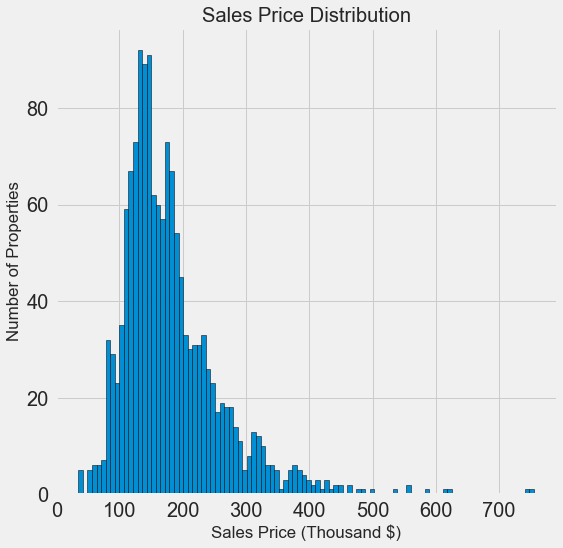

In [45]:
figsize(8, 8)

# Histogram of the SalePrice columns
plt.style.use('fivethirtyeight')
(data['SalePrice']/1000).plot.hist(bins=100, edgecolor = 'k')
plt.xlabel('Sales Price (Thousand $)'); plt.ylabel('Number of Properties'); 
plt.title('Sales Price Distribution');

Most properties are priced between \$100K and \$250K with a right-skewed tail. Let's take a look at selling prices by neighbourhood. 

## Looking for Relationships

In [109]:
# Create a list of neighborhoods with more than 70 observations
neighborhoods = data.dropna(subset=['SalePrice'])
neighborhoods = neighborhoods['Neighborhood'].value_counts()
neighborhoods = list(neighborhoods[neighborhoods.values > 70].index)

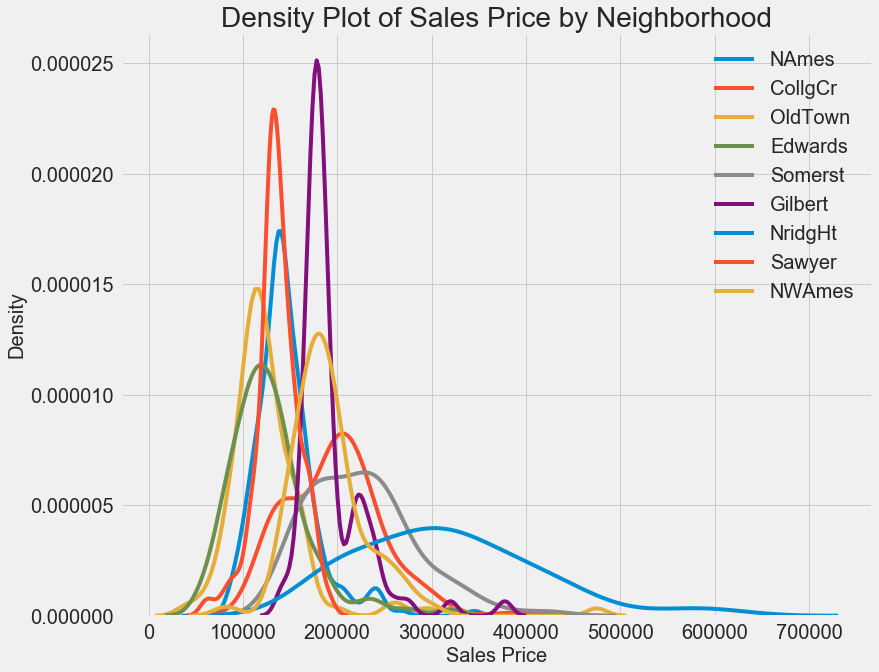

In [76]:
# Plot of distribution of sales price for neighborhoods
figsize(12, 10)

# Plot each borough distribution of sales price
for neighborhood in neighborhoods:
    # Select the neighborhood
    subset = data[data['Neighborhood'] == neighborhood]
    
    # Density plot of Sale Price
    sns.kdeplot(subset['SalePrice'].dropna(),
               label = neighborhood);
    
# label the plot
plt.xlabel('Sales Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Sales Price by Neighborhood', size = 28);

Neighbouorhood does have an effect on sales price as one would expect. In order to use this categorical variable, we'll need to perform one-hot encoding later.

Let's examine the sales price based on the style of house.

In [83]:
# Create a list of neighborhoods with more than 100 observations
housestyles = data.dropna(subset=['SalePrice'])
housestyles = housestyles['HouseStyle'].value_counts()
housestyles = list(housestyles[housestyles.values > 0].index)

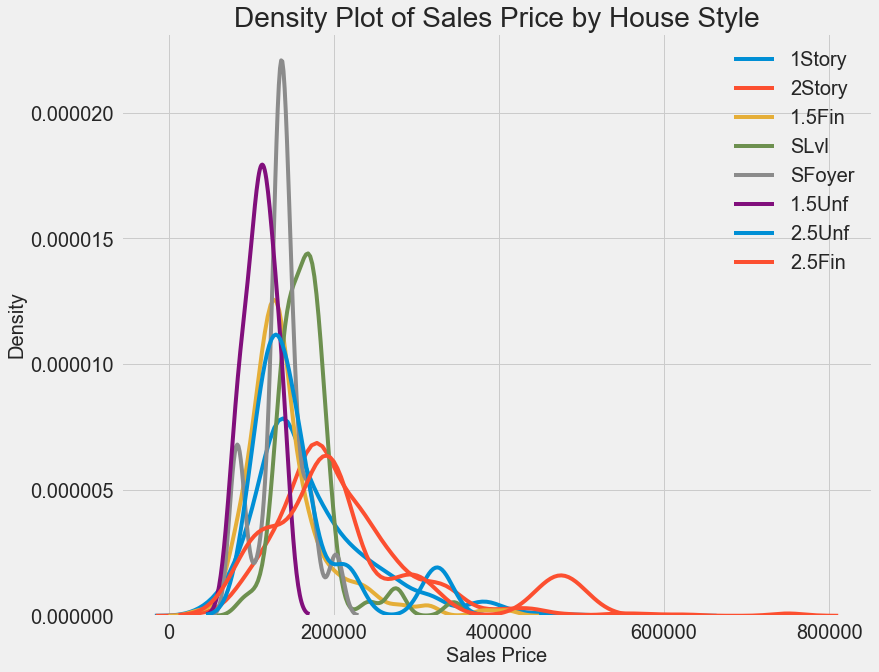

In [84]:
# Plot of distribution of sales price for neighborhoods
figsize(12, 10)

# Plot each borough distribution of sales price
for housestyle in housestyles:
    # Select the neighborhood
    subset = data[data['HouseStyle'] == housestyle]
    
    # Density plot of Sale Price
    sns.kdeplot(subset['SalePrice'].dropna(),
               label = housestyle);
    
# label the plot
plt.xlabel('Sales Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Sales Price by House Style', size = 28);

The majority of houses are clustered around the \$100 - \$200K range and is seems house stlye has less of an impact on selling price than neighbourhood, but it will be still be useful to include this variable in the prediction.

### Removing Outliers
To see if we can find any outliers, lets take a look at histograms of all the numerical variables in one go. This is a high-level plot and we can dive deeper if we need to.

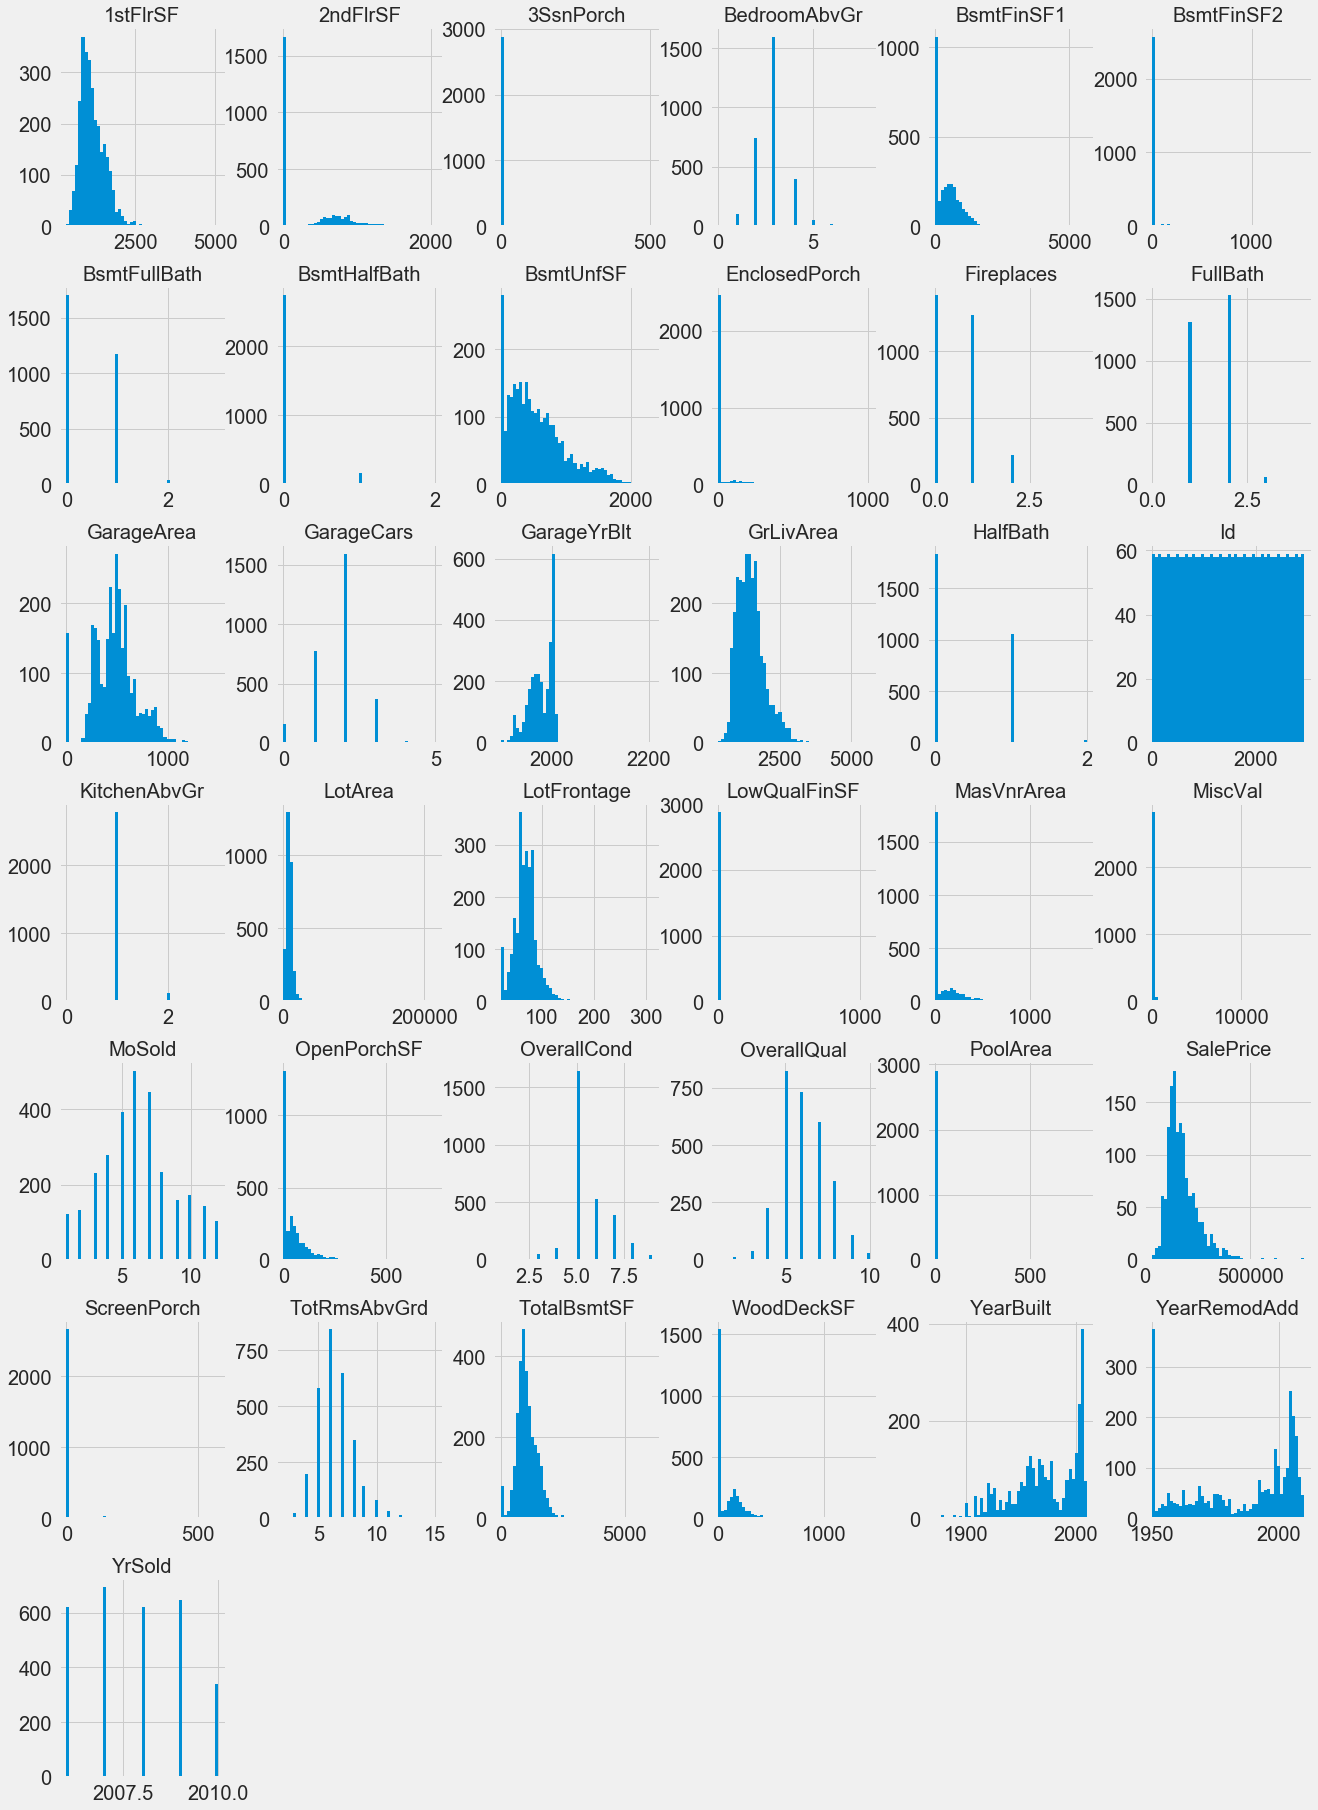

In [87]:
data.hist(bins=50, figsize=(20,30))
plt.show()

A lot of the variables have discrete values, many of which have 0 as a legitimate option, so I won't treat these as outliers. 

## Correlations between Features and Target

In [91]:
# Find all correlations and sort 
correlations_data = data.corr()['SalePrice'].sort_values(ascending=False)

# Print the most positive correlations
print(correlations_data.head(15), '\n')

# Print the most negative correlations
print(correlations_data.tail(15))

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64 

BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


It looks lilke there are a lot of variables which positively correlate with sales price. This makes intuitive sense as the determination of value for a property is complex and multivariate. The negative correlations aren't quite as strong but here we are only indentifying linear relationships. 

Let's take a more detailed look at `OverallQual` and `GrLivArea` since these are the most correlated variables with our sales price.

'OverallQual' is of type int64 with 0 missing values


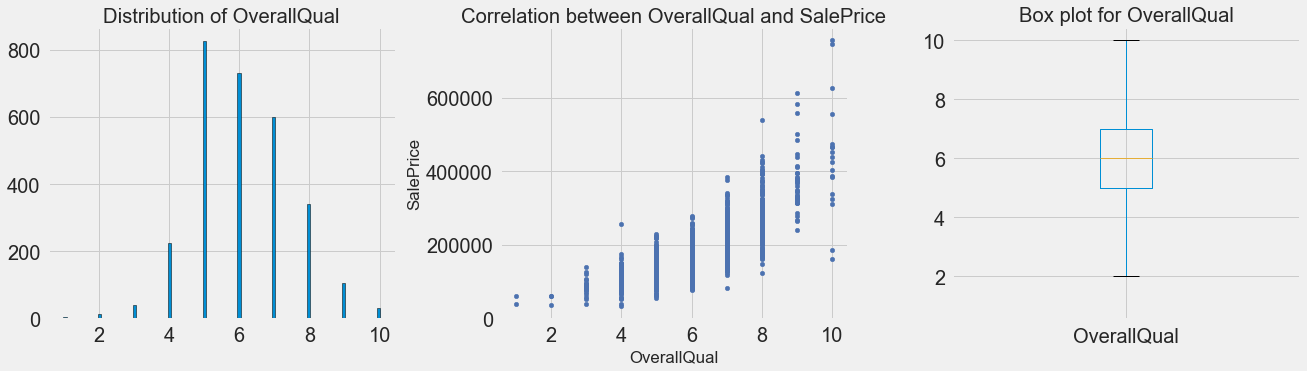

In [97]:
explore_variable(data, "OverallQual", "SalePrice")

'GrLivArea' is of type int64 with 0 missing values


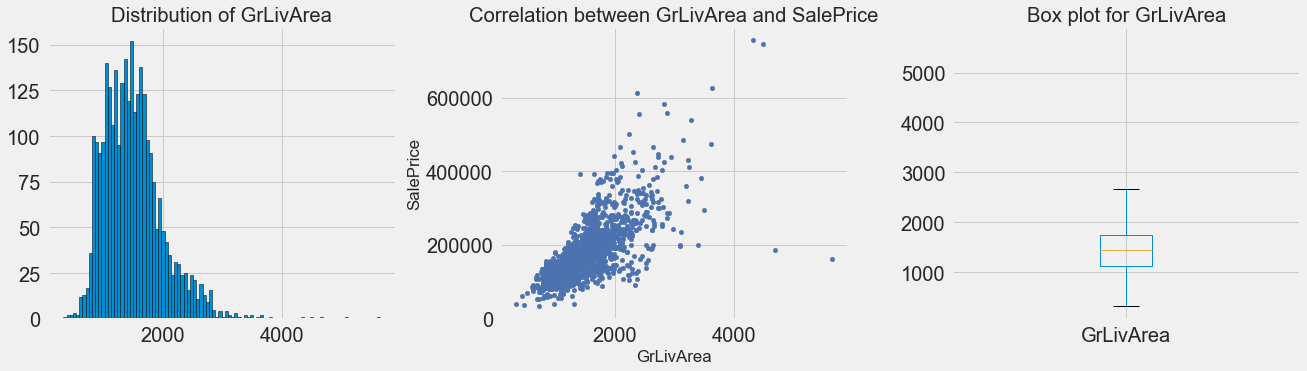

In [96]:
explore_variable(data, "GrLivArea", "SalePrice")

We can see that the amount of square feet above ground (`GrLivArea`) and the overall quality of the property definately influences the selling price. 

To preview how non-linear relationships and categorical variables might influence the sales price, we'll do a little more work. 

It's important to note that we are not identifying the only variables that matter at this stage. We will one-hot encode all categorical variables and use all numerical variables as a baseline model. Once we've done that we'll perform better feature engineering and selection. 

In [92]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'SalePrice':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Neighborhood', 'HouseStyle']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an sale price
features = features.dropna(subset = ['SalePrice'])

# Find correlations with the score 
correlations = features.corr()['SalePrice'].dropna().sort_values()

C:\Users\doron\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [93]:
# Display most negative correlations
correlations.head(15)

Neighborhood_OldTown   -0.192189
Neighborhood_NAmes     -0.188513
Neighborhood_Edwards   -0.179949
Neighborhood_IDOTRR    -0.164056
HouseStyle_1.5Fin      -0.163466
sqrt_EnclosedPorch     -0.160073
Neighborhood_BrkSide   -0.143648
log_KitchenAbvGr       -0.139795
KitchenAbvGr           -0.135907
sqrt_KitchenAbvGr      -0.128729
EnclosedPorch          -0.128578
Neighborhood_Sawyer    -0.128394
Neighborhood_MeadowV   -0.112544
Neighborhood_BrDale    -0.101303
HouseStyle_SFoyer      -0.093090
Name: SalePrice, dtype: float64

In [94]:
# Display most positive correlations
correlations.tail(15)

log_1stFlrSF        0.591264
log_GarageCars      0.594728
log_2ndFlrSF        0.598225
sqrt_1stFlrSF       0.604609
1stFlrSF            0.605852
TotalBsmtSF         0.613581
GarageArea          0.623431
GarageCars          0.640409
log_GrLivArea       0.695118
GrLivArea           0.708624
sqrt_GrLivArea      0.708765
log_OverallQual     0.732961
sqrt_OverallQual    0.767893
OverallQual         0.790982
SalePrice           1.000000
Name: SalePrice, dtype: float64

We do now get a stronger sense of which neighbourhoods negatively affect the sales price, however there isn't too much new infomation here.

## Two-Variable Plots
Let's zoom in a little bit on the overall quality and ground floor living area, but inspecting their correlation by house style.

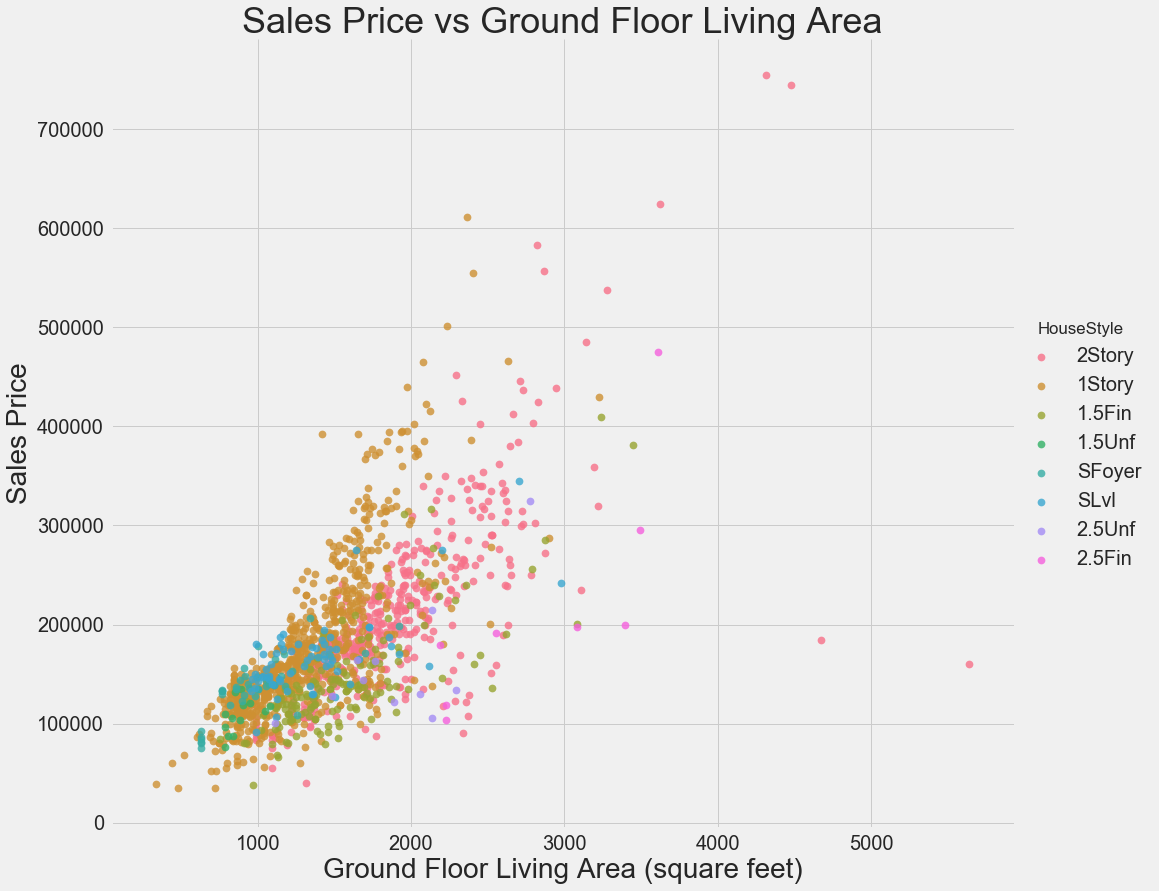

In [111]:
# Use seaborn to plot a scatterplot of Score vs Log Source EUI
sns.lmplot('GrLivArea', 'SalePrice', 
          hue = 'HouseStyle', data = data,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Ground Floor Living Area (square feet)", size = 28)
plt.ylabel('Sales Price', size = 28)
plt.title('Sales Price vs Ground Floor Living Area', size = 36);

Two story properties are the most highly correlated with sales prices. As one would expect, by having more floors, there would be more ground floor living area.

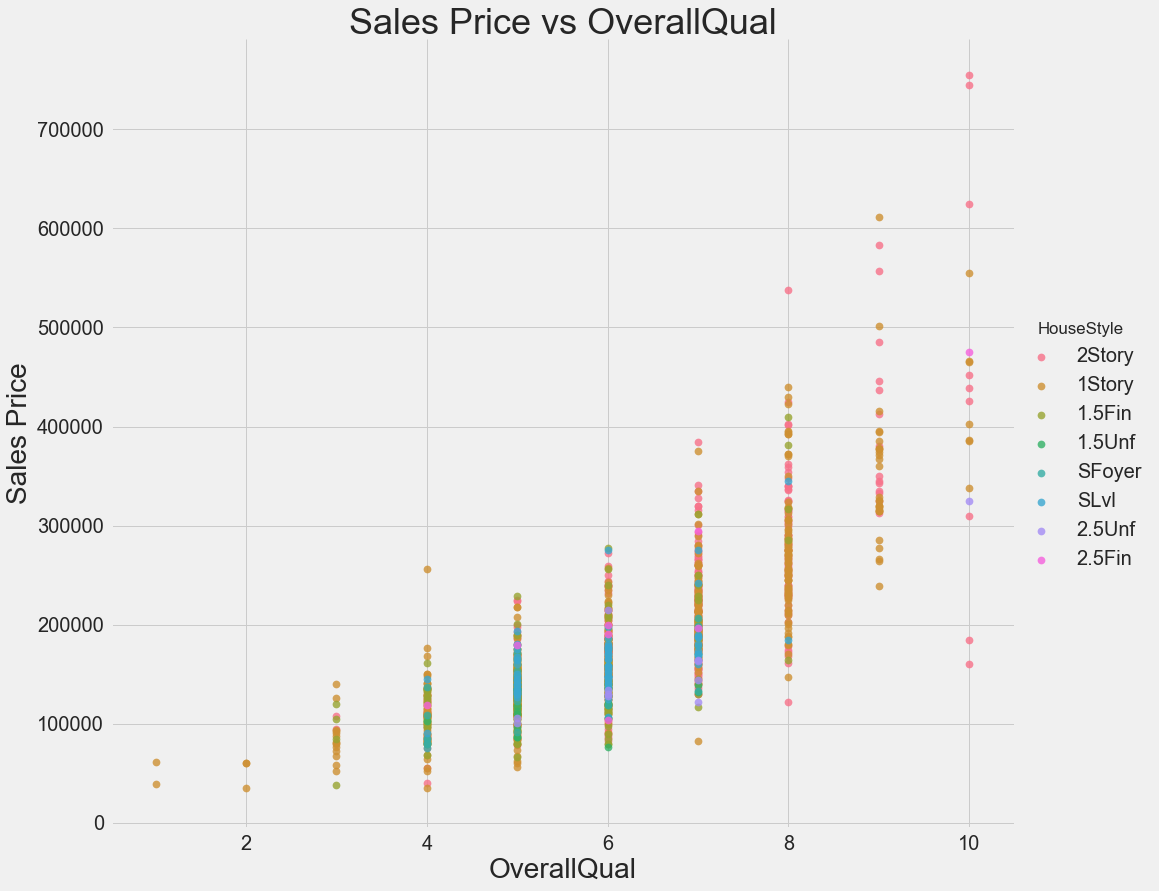

In [112]:
# Use seaborn to plot a scatterplot of Score vs Log Source EUI
sns.lmplot('OverallQual', 'SalePrice', 
          hue = 'HouseStyle', data = data,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("OverallQual", size = 28)
plt.ylabel('Sales Price', size = 28)
plt.title('Sales Price vs OverallQual', size = 36);

While its clear that a higher overall quality correlates with a higher selling price, there isn't a clear relationship between a specific house type and quality. 

# Feature Engineering and Selection

## Remove Collinear Features

### Additional Feature Selection

## Split Into Training and Testing Sets

# Establish a Baseline

## Metric: Root Mean Square Error (Logarithmic)

## Saving Intermediate Files

# Evaluating and Comparing Machine Learning Models

## Read in Data

## Imputing Missing Values

## Scaling Features

## Models to Evaluate

# Model Optimization

## Hyperparameters

## Hyperparameter Tuning with Random Search and Cross Validation

# Evaluate Final Model on the Test Set

# Interprete the Model

## Feature Importances

## Use Feature Importances for Feature Selection

## Locally Interpretable Model-agnostic Explanations

## Examining a Single Decision Tree

# Conclusions

# Exporting Kaggle Submission